In [1]:
import pandas as pd
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
def Cost(C_i, i=0.04/12, periods=20*12): # i = interest rate per month, periods = payback periods (months), can change timescale to not be months
    fv = C_i*((1+i)**periods) #future value calculation
    cost = fv*(i/(((1+i)**periods) - 1))*(1/(1+i)) # monthly payment
    return cost

def GridCost(cg, mon, t, cost, c_fix=0):
    if (mon=="june"):
        df = pd.read_excel ('houston pricing.xlsx', sheet_name='Jun')
        if (cost=="fixed"):
            for n in range (0, t):
                cg = cg + [c_fix*(P_g[n])] 
        elif (cost=="wholesale"):
            for n in range (0, t):
                cg = cg + [df.at[n, "Settlement Point Price"]*(P_g[n])]
        else:
            print('invalid cost input. must be "fixed" or "wholesale"')
            return 0
    elif (mon=="december"):
        if (cost=="fixed"):
            for n in range (0, t):
                cg = cg + [c_fix*(P_g[n])] 
        elif (cost=="wholesale"):
            df = pd.read_excel ('houston pricing.xlsx', sheet_name='Dec')
            for n in range (0, t):
                cg = cg + [df.at[n, "Settlement Point Price"]*(P_g[n])]
        else:
            print('invalid cost input. must be "fixed" or "wholesale"')
            return 0
    else:
        print('invalid month input. must be "june" or "december"')
        return 0
    return cg
    
def Loads(pl, t):
    df_loads = pd.read_excel(r'ethylene 14.xlsx')
    for hour in range(t):
        pl += [df_loads.at[hour, 'P_L_s']]
    return pl

def Solar(ps, mon):
    if (mon=="june"):
        df_solar = pd.read_excel('pvwatts_hourly_Houston_20000kwh.xlsx', sheet_name='j')
        for hour in range(t):
            ps += [df_solar.at[hour, "ACMW"]] 
    elif (mon=="december"):
        df_solar = pd.read_excel('pvwatts_hourly_Houston_20000kwh.xlsx', sheet_name='d')
        for hour in range(t):
            ps += [df_solar.at[hour, "ACMW"]] 
    else:
        print('invalid month input. must be "june" or "december"')
        return 0
    return ps

def SellPrice_e(month, sp):
    if (month=="june"):
        df = pd.read_excel ('Mont Belvieu Ethylene Prices.xlsx', sheet_name='june')
        for n in range (0, 30):
            temp = [df.at[n, "$/ton"]] # cost per Mwh of solar
            for m in range (0, 24):
                sp += temp
    elif (month=="december"):
        df = pd.read_excel ('Mont Belvieu Ethylene Prices.xlsx', sheet_name='december')
        for n in range (0, 31):
            temp = [df.at[n, "$/ton"]] # cost per Mwh of solar
            for m in range (0, 24):
                sp += temp
    else:
        print("invalid month input")
        return 0
    return sp

def SellPrice_h(month, sp):
    if (month=="june"):
        for n in range (0, 30):
            for m in range (0, 24):
                sp += [1]
    elif (month=="december"):
        for n in range (0, 31):
            for m in range (0, 24):
                sp += [1]
    else:
        print("invalid month input")
        return 0
    return sp

def BuyPrice(month, bp):
    if (month=="june"):
        df = pd.read_excel ('Mont Belvieu Ethane Prices.xlsx', sheet_name='june')
        for n in range (0, 30):
            temp = [df.at[n, "$/ton"]] # cost per Mwh of solar
            for m in range (0, 24):
                bp += temp
    elif (month=="december"):
        df = pd.read_excel ('Mont Belvieu Ethane Prices.xlsx', sheet_name='december')
        for n in range (0, 31):
            temp = [df.at[n, "$/ton"]] # cost per Mwh of solar
            for m in range (0, 24):
                bp += [temp]
    else:
        print("invalid month input")
        return 0
    return bp

status: optimal
Battery Capacity [MW]:  9.535210386400593e-06
Minimized Cost: $ 73858953.49777046
Cost of Battery [$]:  0.00823530338844813
Solar Size [MW]:  -2.7011632382462086e-08
Cost of Bought Ethane [tons]:  128036379.42635174
Cost of Sold Ethylene [tons]:  60014635.21967901
Cost of Sold Hydrogen [tons]:  7210.719738422794


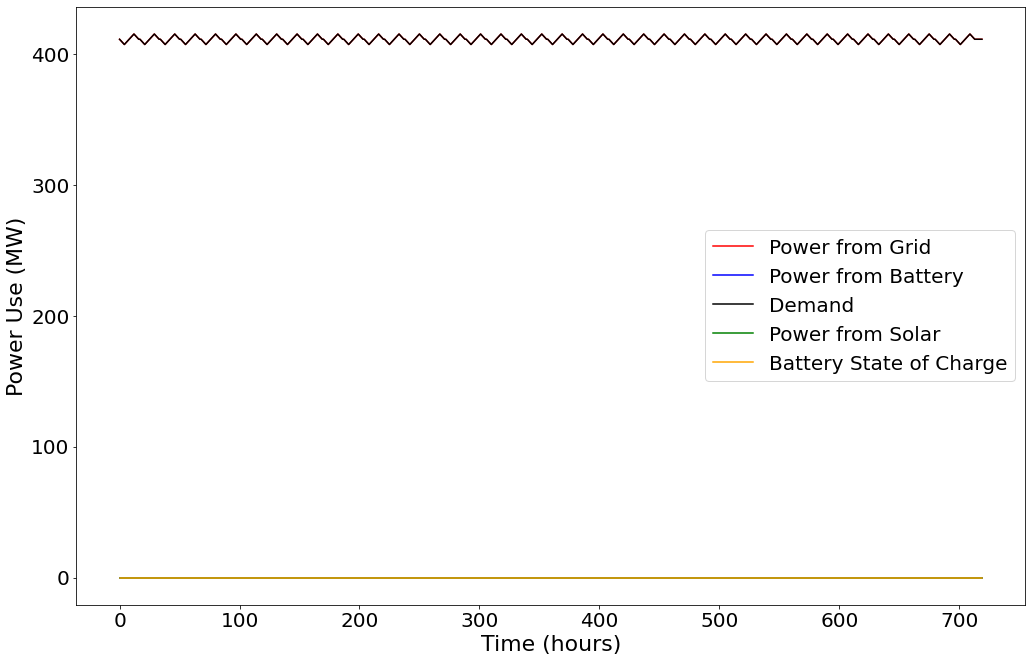

In [3]:
P_ramp = 20*60 # ramp values # ~20 MW/min for gas, coal would be ~2 MW/min
eff = 0.9 # battery efficiency
t = 720 # one month duration (hours)
month = "june" # or "december"
cost = "fixed" # or "wholesale"
c_fix = 19.75 # june 19.75, december 21.19
storage_limit_e = 250 
storage_limit_h = 250 
storage_limit_f = 750 
outage = "no" # or "yes"
# outage_duration = 4 # hours # if outage = yes
# outage_start = 100 # hour # if outage = yes

E_max = cp.Variable() # establishing battery capacity (MW)
E_b = cp.Variable(t+1) # defining battery charge variable
P_g = cp.Variable(t) # power drawn from the grid
P_ch = cp.Variable(t) # battery charge
P_dis = cp.Variable(t) # battery discharge
S_max = cp.Variable() # size of the solar panels
St_e = cp.Variable(t+1) # ethylene storage
Sl_e = cp.Variable(t) # sold ethylene
St_h = cp.Variable(t+1) # hydrogen storage
Sl_h = cp.Variable(t) # sold hydrogen
St_f = cp.Variable(t+1) # feedstock storage
Bt_f = cp.Variable(t+1) # bought feedstock
Pd_e = cp.Variable(t) # production of ethylene
Pd_h = cp.Variable(t) # production of hydrogen
Pd_f = cp.Variable(t) # production of feedstock

C_s = S_max*Cost(1000000*0.89*20)
C_b = E_max*(Cost(143000))
P_L = [] # loads
P_L = Loads(P_L, t)
P_s = [] # power generated by solar
P_s = Solar(P_s, month)
C_g = [] # cost of power from the grid
C_g = GridCost(C_g, month, t, cost, c_fix)
S_p_e = [] # sell price
S_p_e = SellPrice_e(month, S_p_e)
S_p_h = [] # sell price
S_p_h = SellPrice_h(month, S_p_h)
B_p = []
B_p = BuyPrice(month, B_p)

constraints = []
constraints += [P_g >= 0] # power draw is not negative 
constraints += [P_L == P_g + P_dis + -P_ch + P_s*S_max] # the sources sum to load requirements
constraints += [E_b[0] == 0] # battery charge at start is zero
constraints += [P_ch >= 0] # charge into the is not negative
constraints += [1 >= eff] #efficiency cannot be greater than one
constraints += [P_dis >= 0] # discharge from battery is not negative
constraints += [S_max >= 0] # can't have negative solar capacity
constraints += [S_max <= 1] # solar 20000 kW or less
constraints += [P_dis >= 0] # discharge from battery is not negative
# ramp value constraints - power change between time steps can't exceed ramp limit
for n in range (0, t-1): 
    a = P_g[n]
    b = P_g[n+1]
    constraints += [(a - b) <= P_ramp, (a - b) >= -P_ramp] 
    n+1
constraints += [St_e[0] == 0] # storage at time 0 = 0
constraints += [St_h[0] == 0] # storage at time 0 = 0
constraints += [St_f[0] == 0] # storage empty at start
for n in range (0, t):
    constraints += [E_max/4 >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity
    constraints += [E_max/4 >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy
    constraints += [St_e[n] >= 0] # storage between 0 and limit
    constraints += [storage_limit_e >= St_e[n]] # storage between 0 and limit
    constraints += [St_h[n] >= 0] # storage between 0 and limit
    constraints += [storage_limit_h >= St_h[n]] # storage between 0 and limit
    constraints += [St_f[n] >= 0] # storage between 0 and limit
    constraints += [storage_limit_f >= St_f[n]] # storage between 0 and limit
    constraints += [Sl_e[n] >= 0] # selling ethylene not buying
    constraints += [Sl_e[0] == 0] # can't sell in at hour 0
    constraints += [storage_limit_e >= Sl_e[n]] # can't sell more than storage limit in a given timestep
    constraints += [Sl_h[n] >= 0] # selling ethylene not buying
    constraints += [Sl_h[0] == 0] # can't sell in at hour 0
    constraints += [storage_limit_h >= Sl_h[n]] # can't sell more than storage limit in a given timestep
    constraints += [Bt_f[n] >= 0] # buying not selling
#     constraints += [Bt_f[0] == 0] # can't buy in at hour 0
    constraints += [storage_limit_f >= Bt_f[n]] # can't buy more than storage limit in a given timestep
for n in range (1, t+1):
    constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] # battery effectiveness impacts charge/discharge amounts of battery
    constraints += [St_e[n] == St_e[n-1] + Pd_e[n-1] - Sl_e[n-1]] # storage at next time = current + produced - sold
    constraints += [St_h[n] == St_h[n-1] + Pd_h[n-1] - Sl_h[n-1]] # storage at next time = current + produced - sold
    constraints += [St_f[n] == St_f[n-1] + Bt_f[n-1] - Pd_f[n-1]] # storage at next time = current + bought - used
for n in range (0, t+1):
    constraints += [E_b[n] >= 0] # battery charge is not negative
    constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity
if (outage=="yes"):
    for n in range (outage_start, outage_start + outage_duration):
        constraints += [P_g[n] == 0]    
        constraints += [Pd_e[n] >= 0.9*(len(P_L)/sum(P_L))*134.7*P_L[n]]
        constraints += [Pd_e[n] <= (len(P_L)/sum(P_L))*134.7*P_L[n]]
    for n in range(0, outage_start):
        constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]
    for n in range(outage_start + outage_duration, t):
        constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]
elif (outage=="no"):
    for n in range(0, t):
        constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]
for n in range(0, t):
    constraints += [Pd_h[n] == Pd_e[n] * 2.016/28.05]
    constraints += [Pd_f[n] == Pd_e[n] * 30.07/28.05]
P_c = [] # bought ethylene including price
S_l_e = [] # sold ethylene including price
S_l_h = [] # sold ethylene including price
for n in range(t):
    P_c += [Bt_f[n] * B_p[n]]
    S_l_e += [Sl_e[n] * S_p_e[n]]
    S_l_h += [Sl_h[n] * S_p_h[n]]
    
objective = sum(C_g) + C_b + C_s + sum(P_c) - sum(S_l_e) - sum(S_l_h)

prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

#printing results
print("status:", prob.status)
print("Battery Capacity [MW]: ", E_max.value)
print("Minimized Cost: $", prob.value)
print("Cost of Battery [$]: ", C_b.value)
print("Solar Size [MW]: ", S_max.value*20)
print("Cost of Bought Ethane [tons]: ", sum(P_c).value)
print("Cost of Sold Ethylene [tons]: ", sum(S_l_e).value)
print("Cost of Sold Hydrogen [tons]: ", sum(S_l_h).value)

# battery charge variable for plotting
E_plot = []
for n in range (0, t):
    E_plot = E_plot + [E_b.value[n]]
    
#plotting the results  
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit

plt.plot(range(0,t), P_g.value, "red", label = 'Power from Grid') 
plt.plot(range(0,t), P_dis.value, "blue", label = 'Power from Battery')
plt.plot(range(0,t), P_L, "black", label = 'Demand')
plt.plot(range(0,t), P_s*(S_max.value), "green", label = 'Power from Solar') 
plt.plot(range(0,t), E_plot, "orange", label = 'Battery State of Charge')
plt.xlabel("Time (hours)")
plt.ylabel("Power Use (MW)")
# plt.title("Normal Operation: June")
leg = plt.legend()
fig = plt.gcf()
fig.set_size_inches(17, 11)